In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexNoLegend"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = VGG16(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(10136, 512)

In [8]:
bnfeatures = np.reshape(bnfeatures,(bnfeatures.shape[0],-1))

In [9]:
bnfeatures.shape

(10136, 512)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True, random_state=1)

In [ ]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, g

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  5.4min


[CV] .............. C=0.01, gamma=1e-07, score=0.137255, total= 3.3min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.138889, total= 3.3min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.137795, total= 3.3min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.139165, total= 3.3min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.139442, total= 3.3min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.137695, total= 3.3min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.137795, total= 3.3min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  7.0min


[CV] .............. C=0.01, gamma=1e-08, score=0.137795, total= 4.2min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.136986, total= 4.2min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.138751, total= 4.2min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.139165, total= 4.2min
[CV] .............. C=0.01, gamma=1e-08, score=0.138477, total= 4.2min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.137695, total= 4.2min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.137795, total= 4.2min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  7.1min


[CV] .............. C=0.01, gamma=1e-06, score=0.137795, total= 3.3min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.138751, total= 3.3min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.138477, total= 3.3min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.139165, total= 3.3min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.138889, total= 3.3min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.139442, total= 3.3min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.136986, total= 3.4min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 14.0min


[CV] ............. C=0.01, gamma=0.0001, score=0.383858, total= 4.2min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.373047, total= 4.2min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.381605, total= 4.2min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.382874, total= 4.2min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.385757, total= 4.2min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.383548, total= 4.2min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.384921, total= 4.2min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 15.7min


[CV] .............. C=0.01, gamma=0.001, score=0.457843, total= 2.9min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.450787, total= 2.9min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.457677, total= 2.9min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.464286, total= 2.9min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.463826, total= 2.9min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.479125, total= 2.9min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.450049, total= 2.9min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 21.6min


[CV] ............... C=0.01, gamma=0.01, score=0.360040, total= 5.2min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............... C=0.01, gamma=0.01, score=0.357843, total= 5.3min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.375746, total= 5.3min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.363095, total= 5.3min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.354582, total= 5.3min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.203523, total= 5.9min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.213867, total= 5.9min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 23.2min


[CV] ................ C=0.01, gamma=0.1, score=0.212151, total= 4.6min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.195866, total= 4.6min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.182353, total= 4.6min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.198216, total= 5.6min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.197813, total= 5.6min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.203373, total= 5.6min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.191929, total= 5.6min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 29.8min


[CV] ............... C=0.01, gamma=10.0, score=0.152642, total= 5.6min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.156496, total= 5.6min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.138751, total= 3.9min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.150000, total= 5.7min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.138889, total= 3.9min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.150591, total= 5.5min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.153314, total= 5.5min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 36.1min


[CV] ............... C=0.1, gamma=1e-07, score=0.138751, total= 3.9min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.137795, total= 3.9min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.139165, total= 3.9min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.137795, total= 4.0min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.136986, total= 4.0min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.138477, total= 4.0min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.137255, total= 4.0min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 40.2min


[CV] .............. C=0.1, gamma=0.0001, score=0.785433, total= 1.9min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=0.001, score=0.807617, total= 1.7min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.801370, total= 2.0min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.792969, total= 2.0min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=0.001, score=0.837573, total= 1.7min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.774606, total= 2.0min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.799802, total= 1.9min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 42.3min


[CV] ............... C=0.1, gamma=1e-05, score=0.414272, total= 3.7min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.410537, total= 3.6min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.412698, total= 3.7min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.412351, total= 3.8min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.835481, total= 1.7min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.826044, total= 1.7min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.822421, total= 1.7min
[CV] C=0.1, gamma=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 49.9min


[CV] ................. C=0.1, gamma=0.1, score=0.292323, total= 5.4min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ................. C=0.1, gamma=0.1, score=0.288386, total= 5.4min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ................. C=0.1, gamma=0.1, score=0.297725, total= 5.4min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ................. C=0.1, gamma=0.1, score=0.315476, total= 5.4min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.307235, total= 5.5min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.317097, total= 5.5min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.305777, total= 5.7min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 55.7min


[CV] ............... C=1.0, gamma=1e-08, score=0.137695, total= 4.0min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.136986, total= 4.0min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.137255, total= 4.0min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.219488, total= 5.5min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.223541, total= 5.7min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.137795, total= 4.1min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.137795, total= 4.2min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 62.1min


[CV] ............... C=1.0, gamma=1e-07, score=0.138751, total= 4.0min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.138889, total= 4.0min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.138477, total= 4.1min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.409180, total= 3.9min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.416830, total= 3.7min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.139165, total= 4.2min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.417647, total= 3.7min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 65.2min


[CV] .............. C=1.0, gamma=0.0001, score=0.916914, total=  50.8s
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.807540, total= 1.7min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.910433, total=  54.7s
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.814115, total= 1.8min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.909722, total=  51.8s
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.813677, total= 1.9min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.913776, total=  55.9s
[CV] C=1.0, gamma=0.1 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 71.2min


[CV] ................ C=1.0, gamma=0.01, score=0.609298, total= 4.0min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ................ C=1.0, gamma=0.01, score=0.618056, total= 4.0min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................ C=1.0, gamma=0.01, score=0.647117, total= 4.0min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................ C=1.0, gamma=0.01, score=0.614470, total= 4.5min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................ C=1.0, gamma=0.01, score=0.631474, total= 4.6min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................. C=1.0, gamma=0.1, score=0.385519, total= 5.0min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................. C=1.0, gamma=0.1, score=0.360236, total= 5.0min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 78.7min


[CV] ................ C=1.0, gamma=10.0, score=0.291992, total= 5.3min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.300391, total= 5.3min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.285294, total= 6.0min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.286417, total= 5.5min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.281496, total= 6.1min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.291790, total= 5.4min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.137695, total= 4.4min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed: 85.2min


[CV] .............. C=10.0, gamma=1e-06, score=0.812133, total= 1.9min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.787255, total= 1.9min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.419291, total= 3.8min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.424332, total= 3.8min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.797244, total= 1.9min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.775591, total= 2.0min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.891176, total=  49.9s
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed: 87.4min


[CV] .............. C=10.0, gamma=1e-07, score=0.415507, total= 4.0min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.952522, total=  34.8s
[CV] C=10.0, gamma=0.01 ..............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.945437, total=  34.7s
[CV] C=10.0, gamma=0.1 ...............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.944334, total=  36.1s
[CV] C=10.0, gamma=0.1 ...............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.950446, total=  36.2s
[CV] C=10.0, gamma=0.1 ...............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.944223, total=  36.7s
[CV] C=10.0, gamma=0.1 ...............................................
[CV] .............. C=10.0, gamma=0.001, score=0.953187, total= 1.5min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed: 95.8min


[CV] ................ C=10.0, gamma=0.1, score=0.388235, total= 5.6min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] ................ C=10.0, gamma=0.1, score=0.369094, total= 5.4min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] ................ C=10.0, gamma=0.1, score=0.377602, total= 5.4min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] ................ C=10.0, gamma=0.1, score=0.372898, total= 5.7min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ................ C=10.0, gamma=0.1, score=0.410537, total= 5.6min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ................ C=10.0, gamma=0.1, score=0.382470, total= 5.6min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ................ C=10.0, gamma=0.1, score=0.394841, total= 5.7min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 103.9min


[CV] ............. C=100.0, gamma=1e-08, score=0.418236, total= 3.9min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.415675, total= 3.9min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............... C=10.0, gamma=10.0, score=0.296333, total= 6.0min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............... C=10.0, gamma=10.0, score=0.311508, total= 6.0min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.803711, total= 1.8min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............... C=10.0, gamma=10.0, score=0.313121, total= 5.8min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............... C=10.0, gamma=10.0, score=0.297809, total= 5.7min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 433 tasks      | elapsed: 107.1min


[CV] ............. C=100.0, gamma=1e-05, score=0.939484, total=  33.6s
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.942383, total=  36.4s
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.943227, total=  37.9s
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.819085, total= 1.9min
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.930417, total=  39.4s
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.792829, total= 1.9min
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.415507, total= 3.8min
[CV] C=100.0, gamma=0.01 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed: 113.8min


[CV] .............. C=100.0, gamma=0.01, score=0.664016, total= 4.4min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] .............. C=100.0, gamma=0.01, score=0.638943, total= 4.7min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] .............. C=100.0, gamma=0.01, score=0.645418, total= 4.4min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .............. C=100.0, gamma=0.01, score=0.634291, total= 4.7min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .............. C=100.0, gamma=0.01, score=0.627102, total= 4.7min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .............. C=100.0, gamma=0.01, score=0.636905, total= 4.7min
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............... C=100.0, gamma=0.1, score=0.391389, total= 5.4min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 497 tasks      | elapsed: 122.1min


[CV] ............... C=100.0, gamma=1.0, score=0.333665, total= 5.8min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.296875, total= 5.9min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.290196, total= 6.0min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.306262, total= 6.0min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.284449, total= 6.0min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.884766, total=  50.5s
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.896282, total=  48.8s
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed: 124.9min


[CV] .............. C=100.0, gamma=10.0, score=0.313121, total= 5.8min
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.924213, total=  33.1s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.944882, total=  32.8s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.934314, total=  36.1s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.943452, total=  32.3s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.944500, total=  33.9s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.939664, total=  35.7s
[CV] C=1000.0, gamma=0.01 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 140.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03]), 'gamma': array([  1.00000e-08,   1.00000e-07,   1.00000e-06,   1.00000e-05,
         1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [ ]:
top_model.cv_results_

{'mean_fit_time': array([ 223.71198001,  203.59926915,  184.34564252,  210.90929389,
         223.24320567,  159.83319845,  299.32545016,  277.39640582,
         296.85923929,  323.31647232,  219.34007368,  216.28867137,
         226.83446882,  206.47160361,  104.14017668,   93.63943281,
         257.24816256,  311.91791768,  310.13862383,  317.28999228,
         225.99178014,  226.93212938,  216.88446097,   94.78817151,
          43.58955662,   78.7588655 ,  234.87042711,  308.85357361,
         305.20514381,  325.20381622,  238.62999284,  211.48573177,
         102.27004907,   43.14068081,   30.73455865,   83.04228225,
         256.26792078,  318.75856454,  325.0387665 ,  338.19900377,
         215.35151825,   98.17117004,   42.5872967 ,   29.35169556,
          30.75840349,   83.571523  ,  257.81900952,  322.52264261,
         324.79609203,  341.20340025,   97.91678264,   42.33090007,
          29.03940358,   27.77479959,   28.34584832,   80.40924387,
         257.13372459,  321.261

In [ ]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 9.9999999999999995e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 9.9999999999999995e-07},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 1.0000000000000001e-05},
 mean: 0.38240, std: 0.00401, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.46034, std: 0.00802, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.36158, std: 0.00781, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.21014, std: 0.00714, params: {'C': 0.01, 'gamma': 0.10000000000000001},
 mean: 0.19603, std: 0.00599, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.15371, std: 0.00236, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.13822, std: 0.00079, params: {'C': 0.10000000000000001, 'gamma': 1e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.10000000000000001, 'gamma': 9.9999999999999995e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.10000000000000001, 'gamma': 9.99999999999

In [ ]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 1000.0, 'gamma': 0.0001} - score: 0.9473


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


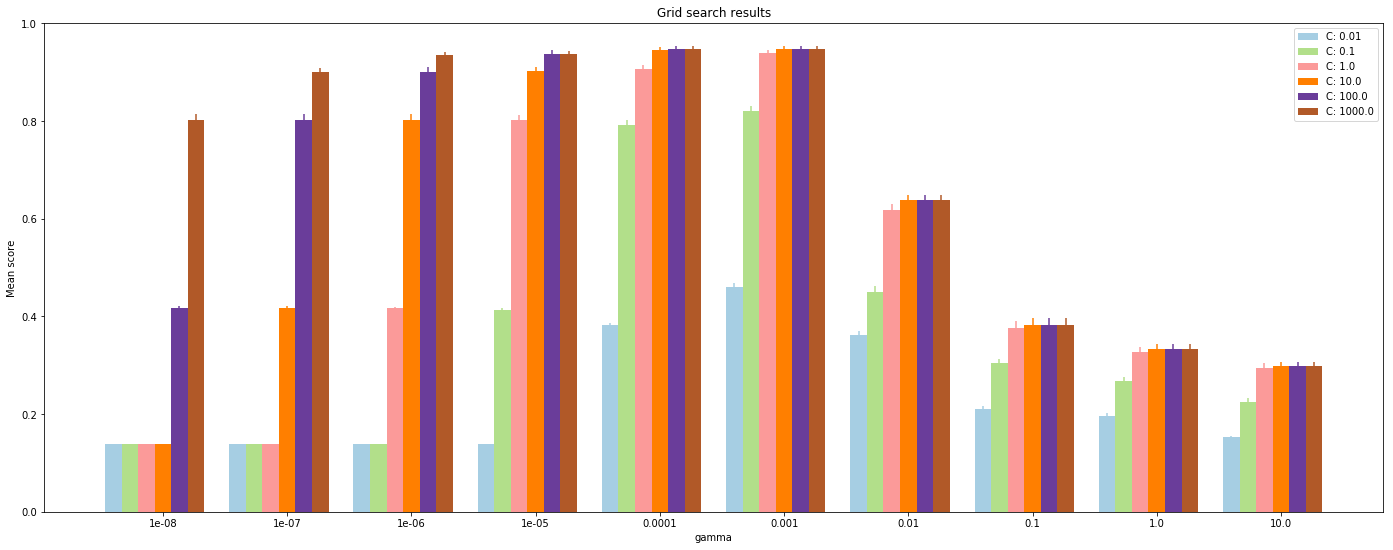

In [ ]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()